In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import time # connaître le temps d'exécution
import os # récupérer le répertoire courant

from numpy import zeros
from numpy import sqrt
from numpy import pi
from numpy import int32

# Pour utiliser des fonctions d'autres fichiers jupyter
# sudo pip3 install ipynb
from ipynb.fs.full.mesFonctions import suppnonmaxima
from ipynb.fs.full.mesFonctions import seuillageParHysteresis
from ipynb.fs.full.mesFonctions import coefficientsDeriche

# sudo pip3 install imageio
from imageio import imread # lire l'image en uint8

# pip3 install opencv-python
import cv2 as cv

path = os.getcwd()
path=path[0:31]+"Donnees/"
print(path)

/home/damien/Bureau/Projet_TIM/Donnees/


#### Image originale

Dimensions image : n= 256  p= 256  z= 4


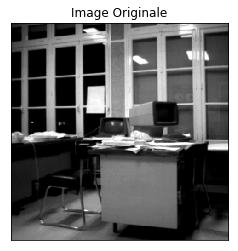

In [2]:
nomImage="office.png"
image = imread(path+nomImage) 

if (len(image.shape)==3):
    n,p,z=image.shape
    print("Dimensions image : n=", image.shape[0], " p=", image.shape[1], " z=", image.shape[2])
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY).astype(int32) # convertir l'image en niveaux de gris
elif (len(image.shape)==2):
    n,p=image.shape
    image=image.astype(np.float64)
    print("Dimensions image : n=", image.shape[0], " p=", image.shape[1])
else:
    print("Les données n'ont pas les bonnes dimensions")
#endif

plt.imshow(image,cmap = 'gray')
plt.title('Image Originale'), plt.xticks([]), plt.yticks([])
plt.show()

#### Choix des parametres (a modifier en fonction de l'image)

In [3]:
# parametres choisis page 179 de l'article pour l'image office.png
alpha = 1; 
omega = 0.0001;

#### Les coefficients du filtre

In [4]:
[c,k,c1,c2,b1,b2,a,a0,a1,a2,a3]=coefficientsDeriche(alpha,omega)

#### Gradient X et Lissage

In [5]:
def filtreDericheRecursif(image, b1, b2, a, a0, a1, a2, a3):
    [n,p]=image.shape
    
    # Gradient
    # Y+
    Yp=zeros([n,p])

    debut_j=0
    #Yp[:,debut_j]=zeros([n,1])
    debut_j=debut_j+1
    Yp[:,debut_j]=image[:,debut_j-1]-b1*Yp[:,debut_j-1]
    debut_j=debut_j+1
    for j in range(debut_j,p,1):
        Yp[:,j]=image[:,j-1]-b1*Yp[:,j-1]-b2*Yp[:,j-2]
    #endfor

    # Y-
    Ym=zeros([n,p])

    fin_j=p-1
    #Ym[:,fin_j]=zeros([n,1])
    fin_j=fin_j-1
    Ym[:,fin_j]=image[:,fin_j+1]-b1*Ym[:,fin_j+1]
    fin_j=fin_j-1
    for j in range(fin_j,-1,-1):
        Ym[:,j]=image[:,j+1]-b1*Ym[:,j+1]-b2*Ym[:,j+2]
    #endfor

    # S
    S=a*(Yp-Ym)
    
    # Lissage
    # R+
    Rp=zeros([n,p])

    debut_i=0
    Rp[debut_i,:]=a0*S[debut_i,:]
    debut_i=debut_i+1
    Rp[debut_i,:]=a0*S[debut_i,:]+a1*S[debut_i-1,:]-b1*Rp[debut_i-1,:]
    debut_i=debut_i+1
    for i in range(debut_i,n,1):
        Rp[i,:]=a0*S[i,:]+a1*S[i-1,:]-b1*Rp[i-1,:]-b2*Rp[i-2,:]
    #endfor

    # R-
    Rm=zeros([n,p])

    fin_i=n-1
    #Rm[fin_i,:]=zeros([1,p])
    fin_i=fin_i-1
    Rm[debut_i,:]=a2*S[fin_i+1,:]-b1*Rm[fin_i+1,:]
    fin_i=fin_i-1
    for i in range(fin_i,-1,-1):
        Rm[i,:]=a2*S[i+1,:]+a3*S[i+2,:]-b1*Rm[i+1,:]-b2*Rm[i+2,:]
    #endfor

    # R
    R=Rm+Rp
    
    return R
#enddef

temps_filtreDericheRecursif 0.014780998229980469


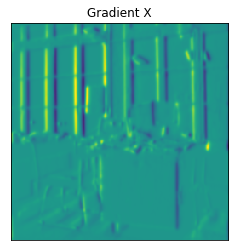

In [6]:
start_time=time.time()
gradientX = filtreDericheRecursif(image, b1, b2, a, a0, a1, a2, a3)
temps_filtreDericheRecursif=time.time()-start_time
print("temps_filtreDericheRecursif", temps_filtreDericheRecursif)

plt.imshow(gradientX)
plt.title('Gradient X'), plt.xticks([]), plt.yticks([])
plt.show()

#### Gradient Y et Lissage

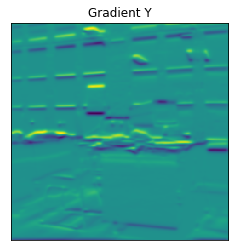

In [7]:
gradientYtranspose = filtreDericheRecursif(image.T, b1, b2, a, a0, a1, a2, a3);
gradientY=gradientYtranspose.T;

plt.imshow(gradientY)
plt.title('Gradient Y'), plt.xticks([]), plt.yticks([])
plt.show()

#### Norme du gradient (magnitude)

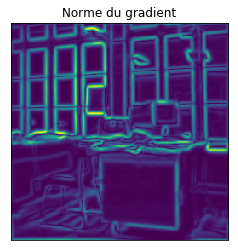

In [8]:
normeGradient = sqrt(pow(gradientX,2) + pow(gradientY,2))

plt.imshow(normeGradient)
plt.title('Norme du gradient'), plt.xticks([]), plt.yticks([])
plt.show()

#### Direction du gradient

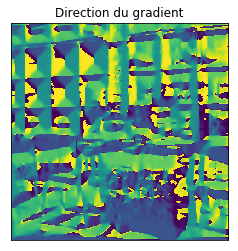

In [9]:
directionGradient = np.arctan2(gradientY,gradientX); # en radian
directionGradient = directionGradient*180/pi # conversion en degre

plt.imshow(directionGradient)
plt.title('Direction du gradient'), plt.xticks([]), plt.yticks([])
plt.show()

#### Suppression des non-maxima locaux

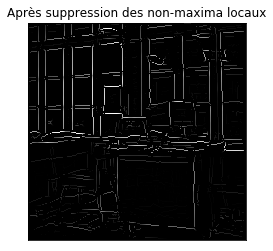

In [10]:
res_suppnonmax = suppnonmaxima(normeGradient, directionGradient)

plt.imshow(res_suppnonmax, cmap = 'gray')
plt.title('Après suppression des non-maxima locaux'), plt.xticks([]), plt.yticks([])
plt.show()

#### Hysteresis thresholding (using two thresholds)

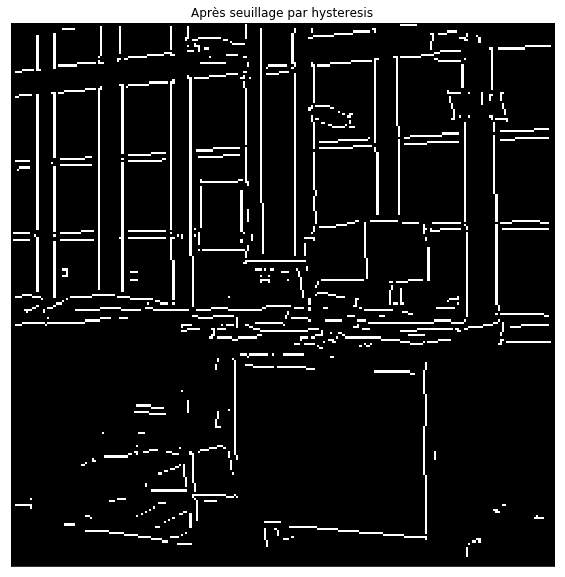

In [11]:
# Seuil minimum
Smin = 20

# Seuil maximum
Smax = 40

res = seuillageParHysteresis(res_suppnonmax, Smin, Smax)

plt.figure(figsize = (50,10))
plt.imshow(res, cmap = 'gray')
plt.title('Après seuillage par hysteresis'), plt.xticks([]), plt.yticks([])
plt.show()